In [205]:
# financial data analysis with arhmm

In [206]:
%%capture
try:
    import dynamax
except ModuleNotFoundError:
    print('installing dynamax')
    %pip install -q dynamax[notebooks]
    import dynamax

In [207]:
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
import seaborn as sns

from dynamax.hidden_markov_model import LinearAutoregressiveHMM
from dynamax.utils.plotting import gradient_cmap
from dynamax.utils.utils import random_rotation

import numpy as np
import pandas as pd
import warnings

In [208]:
sns.set_style("white")
sns.set_context("talk")

color_names = [
    "windows blue",
    "red",
    "amber",
    "faded green",
    "dusty purple",
    "orange",
    "brown",
    "pink"
]

colors = sns.xkcd_palette(color_names)
cmap = gradient_cmap(colors)

### loading the dataset

In [209]:
data = pd.read_csv("Financial-Data/stocks/TSLA.csv")
data = data.dropna()
data.head()

close_diff = np.diff(np.log(data['Close']))[1:]

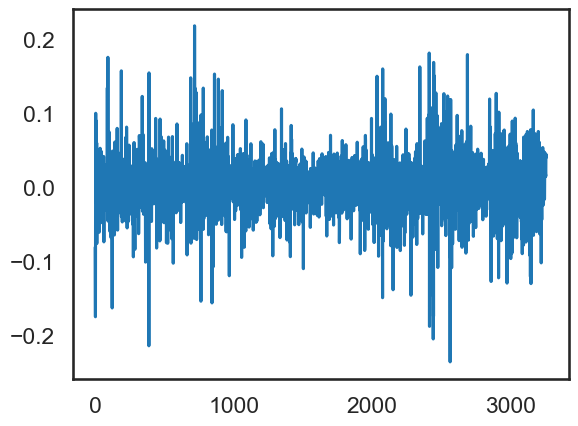

In [210]:
plt.plot(close_diff)

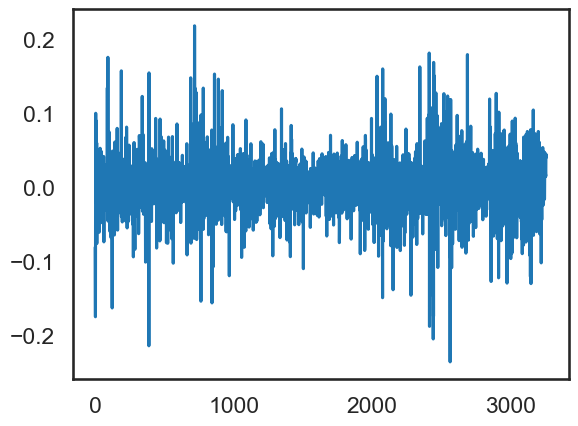

In [211]:
emissions = close_diff
emissions_standardized = (emissions - np.mean(emissions)) / np.std(emissions)
plt.plot(emissions)
#plt.plot(emissions_standardized)

## fitting a model

In [212]:
# Now fit an HMM to the emissions
key1, key2 = jr.split(jr.PRNGKey(0), 2)
num_states = 3
emission_dim = 1
num_lags = 1
start_index = 0


emissions = close_diff[start_index:]
# we don't need to standardize the emissions because they are already in [-0.2,0.2]
# emissions = (emissions - np.mean(emissions)) / np.std(emissions)

emissions = jnp.array(emissions).reshape(-1, 1)
time_bins = len(emissions)

# Initialize with K-Means
arhmm = LinearAutoregressiveHMM(num_states, emission_dim, num_lags=num_lags)
params, props = arhmm.initialize(key=jr.PRNGKey(1), method="kmeans", emissions=emissions)

inputs = arhmm.compute_inputs(emissions)

# Fit with EM
fitted_params, lps = arhmm.fit_em(params, props, emissions, inputs=inputs)

## Plot the log-likelihood

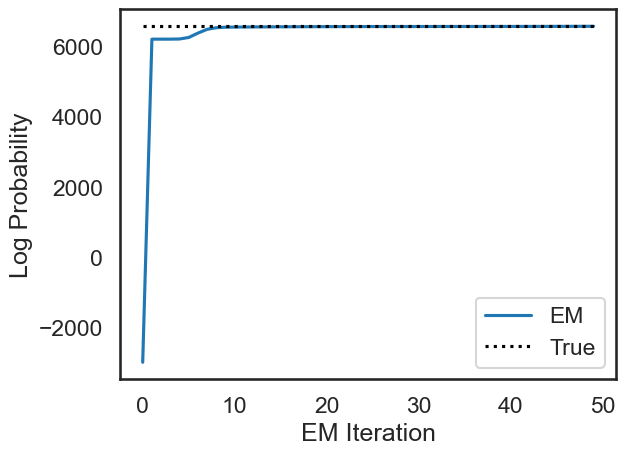

In [213]:
true_lp = arhmm.marginal_log_prob(fitted_params, emissions, inputs=inputs)
plt.plot(lps, label="EM")
plt.plot(true_lp * jnp.ones(len(lps)), ':k', label="True")
plt.xlabel("EM Iteration")
plt.ylabel("Log Probability")
plt.legend(loc="lower right")
plt.show()

## inspecting the parameters

In [214]:
# inspecitng the fitted parameters
for i in range(len(fitted_params)):
    print(fitted_params[i])

ParamsStandardHMMInitialState(probs=Array([0.84608763, 0.07698458, 0.07692778], dtype=float32))
ParamsStandardHMMTransitions(transition_matrix=Array([[0.77651507, 0.07144021, 0.15204477],
       [0.0412482 , 0.5088697 , 0.44988212],
       [0.14512637, 0.78621477, 0.06865887]], dtype=float32))
ParamsLinearRegressionHMMEmissions(weights=Array([[[-0.00449706]],

       [[ 0.07297227]],

       [[-0.07526115]]], dtype=float32), biases=Array([[0.00085269],
       [0.0008614 ],
       [0.00325268]], dtype=float32), covs=Array([[[0.00351961]],

       [[0.00057859]],

       [[0.0003477 ]]], dtype=float32))


# find most likely states

In [215]:
posterior = arhmm.smoother(fitted_params, emissions, inputs=inputs)
most_likely_states = arhmm.most_likely_states(fitted_params, emissions, inputs=inputs)

## plot of most likely states

Text(0, 0.5, 'Close Values')

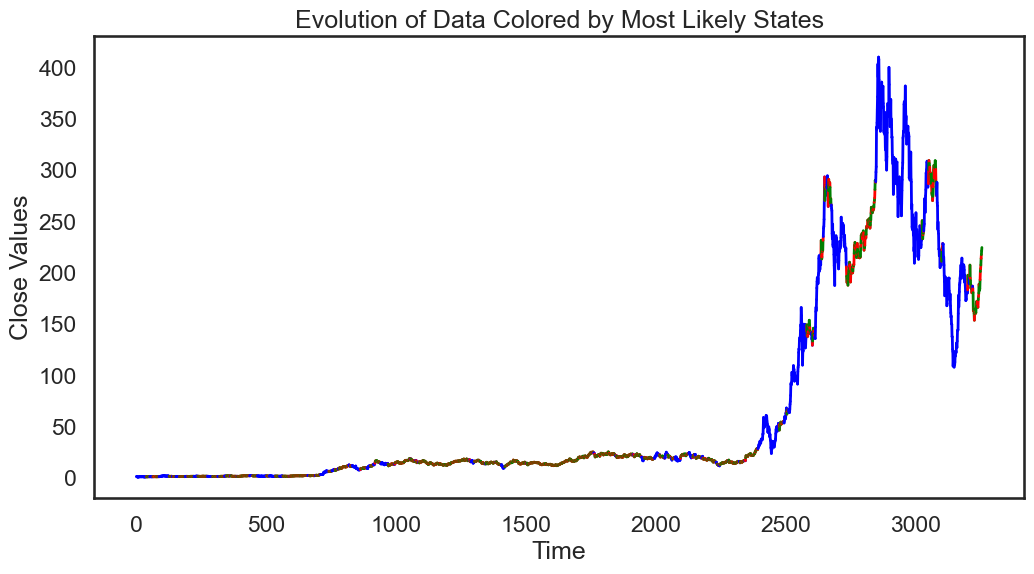

In [216]:
d = data['Close'][start_index:].to_numpy()

colors = ['blue', 'green', 'red', 'purple']
state_colors = [colors[state] for state in most_likely_states]

fig, ax = plt.subplots(figsize=(12, 6))

for i in range(1, len(d)-2):
    ax.plot([i-1, i], [d[i-1], d[i]], color=state_colors[i], linewidth=2)

ax.set_title('Evolution of Data Colored by Most Likely States')
ax.set_xlabel('Time')
ax.set_ylabel('Close Values')

## plot of distribution of hidden states

Text(0.5, 0, 'time')

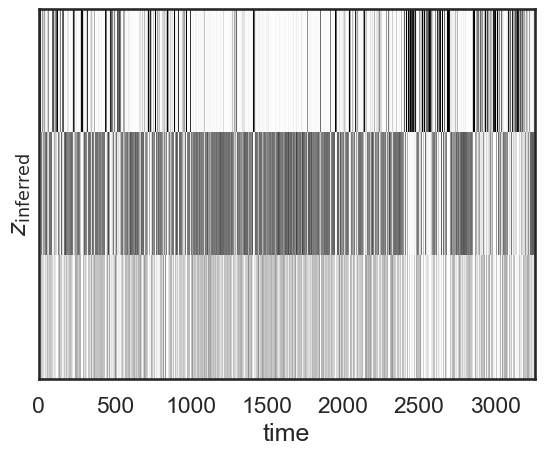

In [217]:
plot_slice = (0, time_bins)
plt.imshow(posterior.smoothed_probs.T, aspect="auto", interpolation="none", cmap="Greys", vmin=0, vmax=1)
plt.xlim(plot_slice)
plt.ylabel("$z_{\\mathrm{inferred}}$")
plt.yticks([])
plt.xlabel("time")

# sample new data and plot them

(3258, 1)


Text(0, 0.5, 'Emissions')

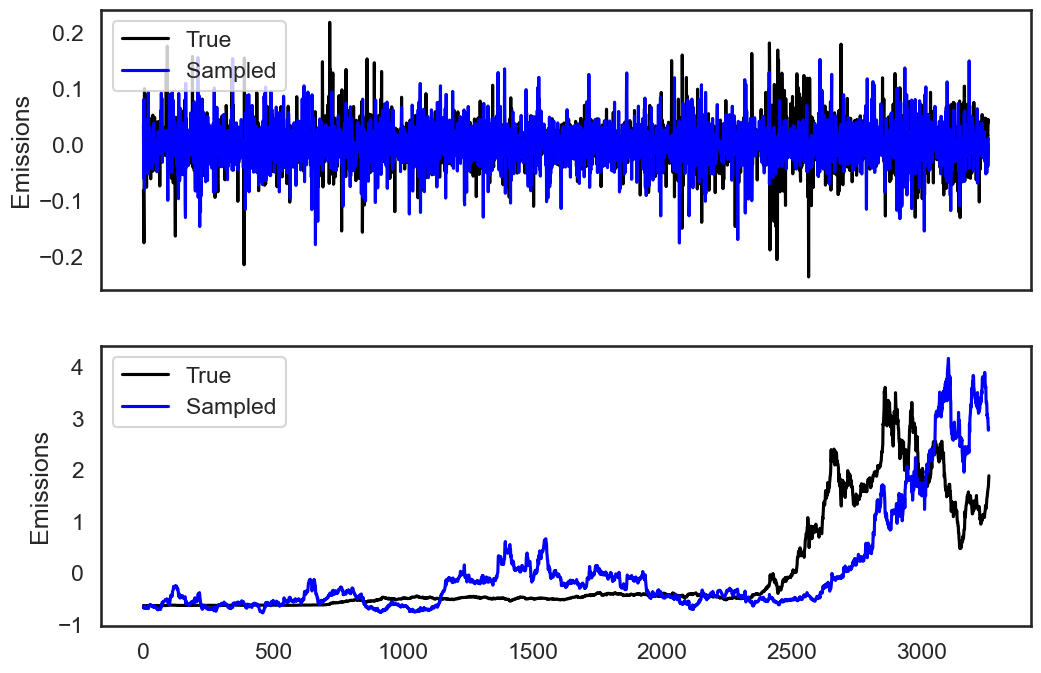

In [218]:
sampled_states, sampled_emissions = arhmm.sample(fitted_params, jr.PRNGKey(0), time_bins)

print(sampled_emissions.shape)

initial_value = data['Close'].iloc[start_index]
recovered_log = np.cumsum(np.concatenate(([np.log(initial_value)], sampled_emissions.reshape(-1))))
recovered_series = np.exp(recovered_log)

fig, ax = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
ax[0].plot(emissions, color="black", label="True")
ax[0].plot(sampled_emissions, color="blue", label="Sampled")
ax[0].legend(loc="upper left")
ax[0].set_ylabel("Emissions")

d = data['Close'][start_index:].to_numpy()
d = (d-np.mean(d))/np.std(d)

# we need to standardize the recovered series
recovered_series = (recovered_series - np.mean(recovered_series)) / np.std(recovered_series)

ax[1].plot(d, color="black", label="True")
ax[1].plot(recovered_series, color="blue", label="Sampled")
ax[1].legend(loc="upper left")
ax[1].set_ylabel("Emissions")

Text(0.5, 0, 'time')

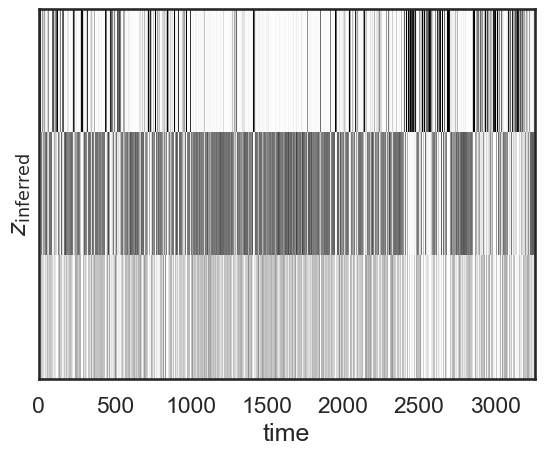

In [219]:
plot_slice = (0, time_bins)
plt.imshow(posterior.smoothed_probs.T, aspect="auto", interpolation="none", cmap="Greys", vmin=0, vmax=1)
plt.xlim(plot_slice)
plt.ylabel("$z_{\\mathrm{inferred}}$")
plt.yticks([])
plt.xlabel("time")

Text(0, 0.5, 'Emissions')

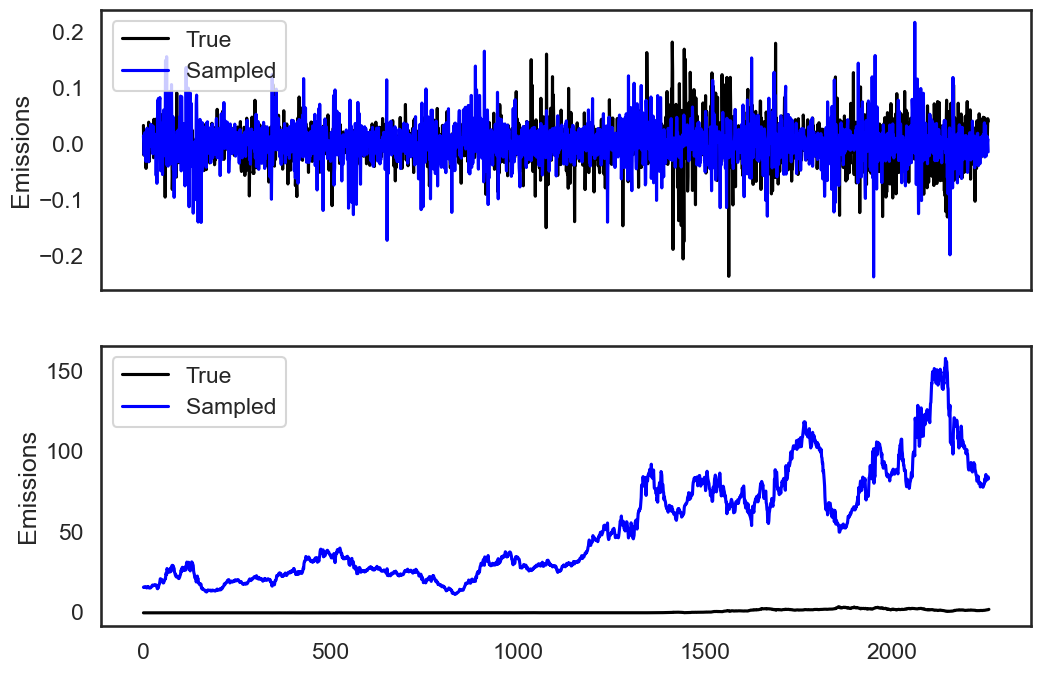

In [224]:
# try to see if the sampling improves with less data, second part of the data

start_index_1 = 1000
emissions_1 = emissions[start_index_1:]
arhmm = LinearAutoregressiveHMM(num_states, emission_dim, num_lags=num_lags)
params, props = arhmm.initialize(key=jr.PRNGKey(1), method="kmeans", emissions=emissions_1)

inputs_1 = arhmm.compute_inputs(emissions_1)

# Fit with EM
fitted_params, lps = arhmm.fit_em(params, props, emissions_1, inputs=inputs_1)
time_bins = len(emissions_1)

sampled_states, sampled_emissions = arhmm.sample(fitted_params, jr.PRNGKey(0), time_bins, np.array(emissions_1[0:num_lags]).reshape(num_lags, emission_dim))

initial_value = data['Close'].iloc[start_index_1]

recovered_log = np.cumsum(np.concatenate(([np.log(initial_value)], sampled_emissions.reshape(-1))))
recovered_series = np.exp(recovered_log)
# we need to standardize the emissions
# recovered_series = (recovered_series - np.mean(recovered_series)) / np.std(recovered_series)

fig, ax = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
ax[0].plot(emissions_1, color="black", label="True")
ax[0].plot(sampled_emissions, color="blue", label="Sampled")
ax[0].legend(loc="upper left")
ax[0].set_ylabel("Emissions")

d = data['Close'][start_index_1:].to_numpy()
d = (d-np.mean(d))/np.std(d)

ax[1].plot(d, color="black", label="True")
ax[1].plot(recovered_series, color="blue", label="Sampled")
ax[1].legend(loc="upper left")
ax[1].set_ylabel("Emissions")

## prediction

In [221]:
key1, key2 = jr.split(jr.PRNGKey(0), 2)
num_states = 4
emission_dim = 1
num_lags = 1
arhmm = LinearAutoregressiveHMM(num_states, emission_dim, num_lags=num_lags)
"""
trying to suppress the stdout of the fit function but with no result
import contextlib
import io

def suppress_output(func):
    def wrapper(*args,**kwargs):
        f = io.StringIO()
        with contextlib.redirect_stdout(f):
            return func(*args, **kwargs)
        return wrapper

@suppress_output
"""




def pred_smoothed_probs(emission, obs):
    """
    Predict the next point using a sequence of observations.
    weight the prediction on the last state distribution
    remember the the emissions are passed as log(return)
    """
    params, props = arhmm.initialize(key=jr.PRNGKey(1), method="kmeans", emissions=emissions)
    inputs = arhmm.compute_inputs(emissions)

    # Fit with EM
    fitted_params, lps = arhmm.fit_em(params, props, emissions, inputs=inputs)
    posterior = arhmm.smoother(fitted_params, emissions, inputs=inputs)
    most_likely_states = arhmm.most_likely_states(fitted_params, emissions, inputs=inputs)
    most_likely_state = most_likely_states[-1]

    transition_matrix = np.array(fitted_params[1]).reshape(num_states, num_states)
    last_state_probs = transition_matrix[most_likely_state]
    last_state_probs = last_state_probs.reshape(num_states, 1)
    
    weight = np.array(fitted_params[2][0]).reshape(-1, 1)
    bias = np.array(fitted_params[2][1]).reshape(-1, 1)
    
    # do i compute the weighted mean before or after doing the exponential??    
    # we are doing the weighted mean before the exponential because the model predicts the log return

    pred_log_return = emission[-1] * weight + bias
    pred_log_return = np.dot(pred_log_return.T, last_state_probs)
    pred_return = np.exp(pred_log_return)
    pred = obs * pred_return


    return pred

In [222]:
print(data['Close'][200])
d = data['Close'][:201].to_numpy()
print(d[-1])
print(data['Close'][201])
pred_smoothed_probs(emissions[:200], data['Close'][200])

1.6619999408721924
1.6619999408721924
1.6759999990463257


KeyboardInterrupt: 

In [ ]:
warnings.simplefilter("ignore")

predictions = []
start = 1500
end = len(emissions)
for i in range(start, end, 1):
    print(i)
    predictions.append(pred_smoothed_probs(emissions[:i+1], data['Close'][i]))

1500


1501


1502


1503


KeyboardInterrupt: 

500 500
(500, 1) (500, 1)


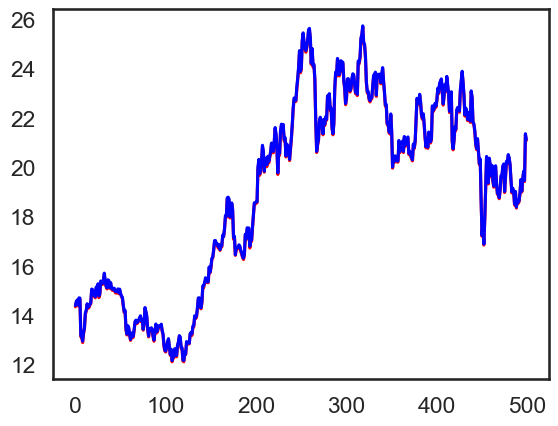

In [ ]:
d = data['Close'][start:end].to_numpy()
d = d.reshape(end - start,-1)
plt.plot(d, color = 'red')
predictions = np.array(predictions).reshape(-1, 1)
plt.plot(predictions, color='blue')
print(len(d), len(predictions))
print(d.shape, predictions.shape)

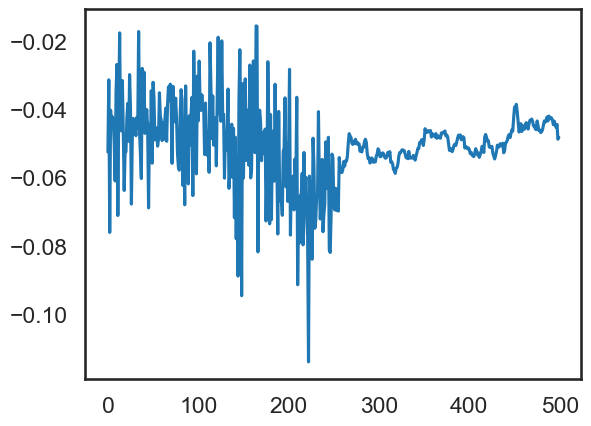

In [ ]:
plt.plot(d-predictions)

In [ ]:
# rss of predictions on log return 
print(np.sum(np.square(d-predictions))/len(d))

0.0026708799569841878
